In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA11'
subj_format = ['nlx']
subj_site = ['UCD']

In [5]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'


In [6]:
ncs_files = [x for x in glob(f'{load_path}/*.ncs')]

In [7]:
ncs_files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA7_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM9_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA6_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM8_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LHB9_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LHB8_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM3_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RAC4_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM2_0005.ncs',
 '/Users/alexandraf

In [8]:
ch_names = []

for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    ch_names.append(chan_name)

ch_file_dict = {} #dictionary mapping electrode name to the its 2 corresponding data files 

for ch in ch_names:
    ch_files = [f for f in ncs_files if ch == f.split('/')[-1].replace('.ncs','').split('_')[0]] #was saving ch 10 with ch 1 before
    ch_file_dict[ch]=ch_files
    
ch_file_dict

ch_file_counts = {}

for ch in ch_file_dict:
    ch_file_counts[ch] = len(ch_file_dict[ch])

In [9]:
ch_file_counts

{'RIA7': 3,
 'LAM9': 3,
 'RIA6': 3,
 'LAM8': 3,
 'LHB9': 3,
 'LHB8': 3,
 'RSM3': 3,
 'RAC4': 3,
 'RSM2': 3,
 'RAC5': 3,
 'RHB1': 3,
 'RIP5': 3,
 'LHB2': 3,
 'LHB3': 3,
 'RIP4': 3,
 'RHH7': 3,
 'RHH6': 3,
 'LAM3': 3,
 'LAM2': 3,
 'RAM1': 3,
 'LHH5': 3,
 'LHH4': 3,
 'RTT9': 3,
 'RTT8': 3,
 'LTT1': 3,
 'RTT10': 3,
 'RFP3': 3,
 'RFP2': 3,
 'RIA10': 3,
 'RTT2': 3,
 'RTT3': 3,
 'RFP9': 3,
 'RFP8': 3,
 'RTT5': 3,
 'RTT4': 3,
 'LTT7': 3,
 'LTT6': 3,
 'Photodiode': 3,
 'RFP4': 3,
 'RFP5': 3,
 'RAC8': 3,
 'RAC9': 3,
 'LHH8': 3,
 'LHH9': 3,
 'RIA1': 3,
 'RIP9': 3,
 'RIP8': 3,
 'LHB5': 3,
 'RIP2': 3,
 'RIP3': 3,
 'LHB4': 3,
 'RSM4': 3,
 'RAC3': 3,
 'RHB7': 3,
 'RSM5': 3,
 'RHB6': 3,
 'RAC2': 3,
 'RAM6': 3,
 'RAM7': 3,
 'LHH2': 3,
 'LHH3': 3,
 'RIP10': 3,
 'RHH1': 3,
 'LAM4': 3,
 'LAM5': 3,
 'LTT9': 3,
 'LTT8': 3,
 'LTT2': 3,
 'LTT3': 3,
 'RTT1': 3,
 'RFP1': 3,
 'RHB9': 3,
 'RHB8': 3,
 'RSM1': 3,
 'RAC6': 3,
 'RHB2': 3,
 'RHB3': 3,
 'RAC7': 3,
 'RAM2': 3,
 'RAM3': 3,
 'LHH6': 3,
 'LHH7': 3,
 'RHH4'

In [8]:
name = 'RSM1'

In [10]:
files = [f for f in ncs_files if name in f]
files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM1_0006.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM1_0007.ncs']

In [11]:
data1 = nlx_utils.load_ncs(files[0])
data2 = nlx_utils.load_ncs(files[1])
data2 = nlx_utils.load_ncs(files[1])

In [13]:
len(data1['data'])

11581440

In [16]:
data1

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM1_0006.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 5082628e-b772-4307-bb37-7af6b1fe7085\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\RSM1_0006.ncs"\r\n-TimeCreated 2021/06/19 09:14:00\r\n-TimeClosed 2021/06/19 10:04:17\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName RSM1\r\n-NumADChannels 1\r\n-ADChannel 46\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [15]:
data2

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RSM1_0007.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID dc6bb7fa-0eff-4601-b603-cdaea9dbe759\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\RSM1_0007.ncs"\r\n-TimeCreated 2021/06/19 10:04:17\r\n-TimeClosed 2021/06/19 10:38:52\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName RSM1\r\n-NumADChannels 1\r\n-ADChannel 46\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [14]:
len(data2['data'])

6253568

In [17]:
depth_name = 'LAM1'
photo_name = 'Photodiode'

In [18]:
depth_files = [f for f in ncs_files if depth_name in f]
depth_files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0005.ncs']

In [9]:
photo_files = [f for f in ncs_files if photo_name in f]
photo_files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/Photodiode_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/Photodiode_0005.ncs']

In [19]:
depth_data1 = nlx_utils.load_ncs(depth_files[0])
depth_data2 = nlx_utils.load_ncs(depth_files[1])

In [21]:
depth_data2

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0005.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 3c88f4f4-3cc2-4f4e-af74-a24843ed1700\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\LAM1_0005.ncs"\r\n-TimeCreated 2021/06/19 08:57:54\r\n-TimeClosed 2021/06/19 09:14:01\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName LAM1\r\n-NumADChannels 1\r\n-ADChannel 82\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [35]:
depth_data1.keys()

dict_keys(['file_path', 'raw_header', 'header', 'data', 'data_units', 'sampling_rate', 'channel_number', 'timestamp', 'time', 'time_units'])

In [91]:
depth_data1['data'][-1]

-26033

In [90]:
depth_data2['data'][0]

-5453

In [ ]:
1624097575852166

In [40]:
depth_data2['timestamp'][-1]

1624094046182833

In [14]:
depth_data2

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0005.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 3c88f4f4-3cc2-4f4e-af74-a24843ed1700\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\LAM1_0005.ncs"\r\n-TimeCreated 2021/06/19 08:57:54\r\n-TimeClosed 2021/06/19 09:14:01\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName LAM1\r\n-NumADChannels 1\r\n-ADChannel 82\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [69]:
(depth_data1['time'][0]-depth_data2['time'][-1])*(1*10**(-6))

3529.669333

In [82]:
len(depth_data2['time'])

3042816

In [73]:
len(depth_data1['time'])

6253568

In [83]:
3042816 +6253568

9296384

In [85]:
np.hstack((depth_data2['time'],depth_data1['time']))

(9296384,)

In [86]:
depth_time_array = np.hstack((depth_data2['time'],depth_data1['time']))

In [87]:
depth_data_array = np.hstack((depth_data2['data'],depth_data1['data']))

In [92]:
depth_data_array[-1]

-26033

In [15]:
photo_data1 = nlx_utils.load_ncs(photo_files[0]) #4000
photo_data2 = nlx_utils.load_ncs(photo_files[1]) #4000

In [16]:
photo_data1

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/Photodiode_0007.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 5bb4d6ae-2075-4606-8dcd-aafc2e28a7c0\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\Photodiode_0007.ncs"\r\n-TimeCreated 2021/06/19 10:04:20\r\n-TimeClosed 2021/06/19 10:38:56\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "Source 05 Panel Ground"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName Photodiode\r\n-NumADChannels 1\r\n-ADChannel 129\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFr

In [17]:
photo_data2

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/Photodiode_0005.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID a338a65e-ddb1-459b-b836-c22f5952aa99\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\Photodiode_0005.ncs"\r\n-TimeCreated 2021/06/19 08:57:08\r\n-TimeClosed 2021/06/19 09:14:03\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0009"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName Photodiode\r\n-NumADChannels 1\r\n-ADChannel 129\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency

In [110]:
photo_data1['time'][0] - photo_data2['time'][-1]

3529669333

In [111]:
photo_data2['time'][0] - photo_data1['time'][-1]

18446744067856043216

In [103]:
photo_data_array = np.hstack((photo_data2['data'],photo_data1['data']))

In [104]:
photo_data_array = np.hstack((photo_data2['data'],photo_data1['data']))

In [105]:
sr = 4000 #for all files

In [106]:
photo_info1 = mne.create_info([photo_files[0]],sr)
photo_info1
               

<Info | 7 non-empty values
 bads: []
 ch_names: ...
 chs: 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2000.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 4000.0 Hz
>

In [107]:
photo_mne1 = mne.io.RawArray([photo_data_array], photo_info1)
photo_mne1


<RawArray | 1 x 9296384 (2324.1 s), ~70.9 MB, data loaded>

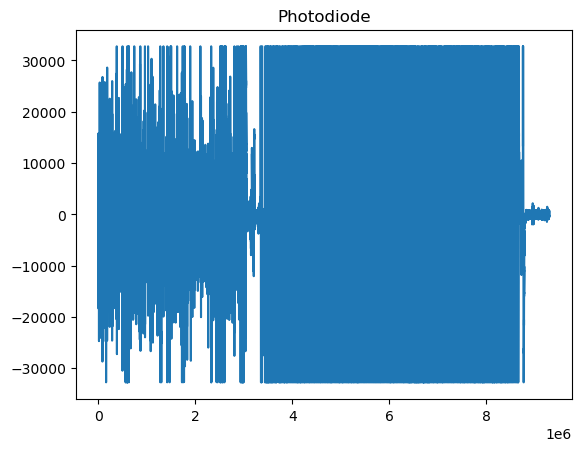

In [108]:
plt.plot(photo_mne1._data[0,]) #hopefully 
plt.title("Photodiode")
plt.show()

In [28]:
photo_info2 = mne.create_info([photo_files[1]],photo_data2['sampling_rate'])
photo_info2
                 

<Info | 7 non-empty values
 bads: []
 ch_names: ...
 chs: 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2000.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 4000.0 Hz
>

In [29]:
depth_info1 = mne.create_info([depth_files[0]],depth_data1['sampling_rate'])
depth_info1
             

<Info | 7 non-empty values
 bads: []
 ch_names: ...
 chs: 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2000.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 4000.0 Hz
>

In [30]:
depth_info2 = mne.create_info([depth_files[1]],depth_data2['sampling_rate'])
depth_info2

<Info | 7 non-empty values
 bads: []
 ch_names: ...
 chs: 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2000.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 4000.0 Hz
>

In [31]:
photo_mne1 = mne.io.RawArray([photo_data1['data']], photo_info1)
photo_mne1


<RawArray | 1 x 6253568 (1563.4 s), ~47.7 MB, data loaded>

In [32]:
photo_mne2 = mne.io.RawArray([photo_data2['data']], photo_info2)
photo_mne2

<RawArray | 1 x 3042816 (760.7 s), ~23.2 MB, data loaded>

In [33]:
depth_mne1 = mne.io.RawArray([depth_data1['data']], depth_info1)
depth_mne1

<RawArray | 1 x 6253568 (1563.4 s), ~47.7 MB, data loaded>

In [34]:
depth_mne2 = mne.io.RawArray([depth_data2['data']], depth_info2)
depth_mne2

<RawArray | 1 x 3042816 (760.7 s), ~23.2 MB, data loaded>

In [ ]:
file1 = nlx_utils.load_ncs(ch_file_dict[ch][0])
file2 = nlx_utils.load_ncs(ch_file_dict[ch][1])

In [ ]:
if (file1['time'][0] - file2['time'][-1]) > (file2['time'][0] - file1['time'][-1]): #if first difference larger - file 1 comes first, if second difference is larger file 2 comes first 
    first_file = file1
    second_file = file2
    print(first_file['file_path'])
elif (file1['time'][0] - file2['time'][-1]) < (file2['time'][0] - file1['time'][-1]):
        first_file = file2
        second_file = file1
        print(first_file['file_path'])

In [ ]:
(file1['time'][0] - file2['time'][-1]) > (file2['time'][0] - file1['time'][-1]) #if first difference larger - file 1 comes first, if second difference is larger file 2 comes first 

In [ ]:
### some channels have 3 files not just 2 

In [ ]:
ch_names = []

for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    ch_names.append(chan_name)

ch_file_dict = {} #dictionary mapping electrode name to the its 2 corresponding data files 

for ch in ch_names:
    ch_files = [f for f in ncs_files if ch == f.split('/')[-1].replace('.ncs','').split('_')[0]] #was saving ch 10 with ch 1 before
    ch_file_dict[ch]=ch_files
    
ch_file_dict

ch_file_counts = {}

for ch in ch_file_dict:
    ch_file_counts[ch] = len(ch_file_dict[ch])

    

In [18]:
ch_names = []

for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    ch_names.append(chan_name)

In [19]:
ch_file_dict = {} #dictionary mapping electrode name to the its 2 corresponding data files 

for ch in ch_names:
    ch_files = [f for f in ncs_files if ch == f.split('/')[-1].replace('.ncs','').split('_')[0]] #was saving ch 10 with ch 1 before
    ch_file_dict[ch]=ch_files
    
ch_file_dict

{'RIA7': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA7_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA7_0006.ncs'],
 'LAM9': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM9_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM9_0005.ncs'],
 'RIA6': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA6_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RIA6_0006.ncs'],
 'LAM8': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM8_0007.ncs',
  '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/LAM8_0005.ncs'],
 'LHB9': ['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/

In [20]:
ch_file_counts = {}

for ch in ch_file_dict:
    ch_file_counts[ch] = len(ch_file_dict[ch])

In [21]:
ch_file_counts

{'RIA7': 2,
 'LAM9': 2,
 'RIA6': 2,
 'LAM8': 2,
 'LHB9': 2,
 'LHB8': 2,
 'RAC4': 2,
 'RAC5': 2,
 'RHB1': 3,
 'LHB3': 2,
 'LHB2': 2,
 'LAM3': 2,
 'LAM2': 2,
 'RAM1': 2,
 'LHH5': 2,
 'LHH4': 2,
 'RSM2': 2,
 'RSM3': 2,
 'RIP4': 2,
 'RIP5': 2,
 'RHH7': 2,
 'RHH6': 2,
 'RTT9': 2,
 'RTT8': 2,
 'LTT1': 2,
 'RTT10': 2,
 'RFP3': 3,
 'RFP2': 3,
 'RIA10': 2,
 'RFP9': 3,
 'RFP8': 3,
 'RTT3': 2,
 'RTT2': 2,
 'LTT7': 2,
 'LTT6': 2,
 'Photodiode': 2,
 'RFP4': 3,
 'RFP5': 3,
 'RTT4': 2,
 'RTT5': 2,
 'LHH8': 2,
 'LHH9': 2,
 'RIA1': 2,
 'RIP9': 2,
 'RIP8': 2,
 'RAC3': 2,
 'RHB7': 3,
 'RHB6': 3,
 'RAC2': 2,
 'RAM6': 2,
 'RAM7': 2,
 'LHH2': 2,
 'LHH3': 2,
 'LHB4': 2,
 'LHB5': 2,
 'LAM4': 2,
 'LAM5': 2,
 'RAC9': 2,
 'RAC8': 2,
 'RIP3': 2,
 'RIP2': 2,
 'RHH1': 2,
 'RIP10': 2,
 'RSM5': 2,
 'RSM4': 2,
 'LTT9': 2,
 'LTT8': 2,
 'RTT1': 2,
 'LTT3': 2,
 'LTT2': 2,
 'RFP1': 3,
 'RHB9': 3,
 'RHB8': 3,
 'RSM1': 2,
 'RHB2': 3,
 'RHB3': 3,
 'RAM2': 2,
 'RAM3': 2,
 'LHH6': 2,
 'LHH7': 2,
 'RHH4': 2,
 'RHH5': 2,
 'LAM1'

In [9]:
files = [f for f in ncs_files if 'RFP9' in f]
files

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0006.ncs']

In [10]:
file1 = nlx_utils.load_ncs(files[0]) 
file2 = nlx_utils.load_ncs(files[1]) 
file3 = nlx_utils.load_ncs(files[2]) 
 

In [11]:
file1

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0005.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 5df36647-2ad8-45b8-803a-dbe3b2628a2d\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\RFP9_0005.ncs"\r\n-TimeCreated 2021/06/19 08:58:31\r\n-TimeClosed 2021/06/19 09:14:00\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName RFP9\r\n-NumADChannels 1\r\n-ADChannel 45\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [12]:
file2

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0007.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 1097cf78-ad57-4935-88bc-7cd752630541\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\RFP9_0007.ncs"\r\n-TimeCreated 2021/06/19 10:04:17\r\n-TimeClosed 2021/06/19 10:38:52\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName RFP9\r\n-NumADChannels 1\r\n-ADChannel 45\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [13]:
file3

{'file_path': '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0006.ncs',
 'raw_header': b'######## Neuralynx Data File Header\r\n-FileType NCS\r\n-FileVersion 3.4\r\n-FileUUID 163bfef3-17cc-43b7-aea0-b9677ac20158\r\n-SessionUUID 0c890e78-dcfb-4649-be9b-bcb0997c5f0c\r\n-ProbeName \r\n-OriginalFileName "D:\\PegasusData\\DA11\\2021-06-18_17-01-21\\RFP9_0006.ncs"\r\n-TimeCreated 2021/06/19 09:14:00\r\n-TimeClosed 2021/06/19 10:04:17\r\n\r\n-RecordSize 1044\r\n-ApplicationName Pegasus "2.2.0 "\r\n-AcquisitionSystem AcqSystem1 ATLAS\r\n-ReferenceChannel "AD Channel 0081"\r\n-SamplingFrequency 4000\r\n-ADMaxValue 32767\r\n-ADBitVolts 0.000000030517578125000001\r\n-AcqEntName RFP9\r\n-NumADChannels 1\r\n-ADChannel 45\r\n-InputRange 1000\r\n-InputInverted True\r\n\r\n-DSPLowCutFilterEnabled True\r\n-DspLowCutFrequency 0.1\r\n-DspLowCutNumTaps 0\r\n-DspLowCutFilterType DCO\r\n-DSPHighCutFilterEnabled True\r\n-DspHighCutFrequency 1000\r\n-DspHighCu

In [14]:
start_times = [file1['time'][0],file2['time'][0],file3['time'][0]]
np.where(min(start_times))

(array([0]),)

In [15]:
remove_index = np.argmin(start_times)

In [16]:
remove_index

0

In [22]:
ch_file_dict['RFP9']

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0005.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0006.ncs']

In [23]:
test = ch_file_dict['RFP9']

In [24]:
test.pop(remove_index)
test

['/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0007.ncs',
 '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/DA11/raw_nlx/RFP9_0006.ncs']